**Example 2.3:** Typical effects of varying the number of intensity levels in a digital image

> This code is written with Julia v1.0.0, Images v0.16.1

In [1]:
using Printf # format string in C style
using Images # core package for image

在Julia 的`Images`中，图片默认是以“归一化的非浮动的浮点数“`N0f8`存储，即`Norm{UInt8,8}`（Normalized, with 0 integer bits and 8 fractional bits）。换句话说，像素值只能够取[0,1]之间的256个。Check [FixedPointNumbers](https://github.com/JuliaMath/FixedPointNumbers.jl) for more information

这样设计的好处是统一了图片的存储方式，避免了Int与Float类型之间的混淆，从而避免了

1. 不同算法之间图片数据存储类型不明确导致的bug
2. 类型转换带来的数值误差

452×374 Array{Gray{N0f8},2} with eltype Gray{Normed{UInt8,8}}
MIN:Gray{N0f8}(0.047)	MAX:Gray{N0f8}(1.0)


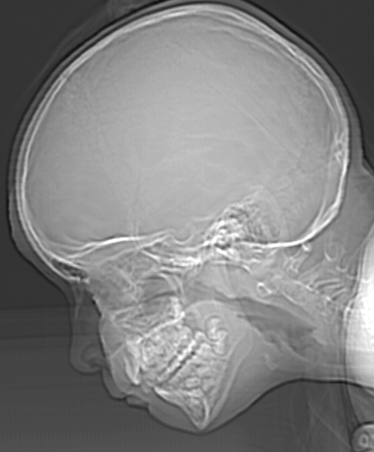

In [2]:
# load the original image
ori_img = load("Data/Fig0221(a).tif")

@printf "%s\n" summary(ori_img)
@printf "MIN:%s\tMAX:%s\n" extrema(ori_img)...
ori_img

当然，我们也可以选择输出其`UInt8`类型的值

In [3]:
# See what image intensities are
ori_img_UInt = rawview(channelview(ori_img))

@printf "%s\n" summary(ori_img_UInt)
@printf "MIN:%s\tMAX:%s\n" extrema(ori_img_UInt)... 
@printf "这是图片UInt8的十六进制表示"
ori_img_UInt

452×374 rawview(reinterpret(N0f8, ::Array{Gray{N0f8},2})) with eltype UInt8
MIN:12	MAX:255
这是图片UInt8的十六进制表示

452×374 rawview(reinterpret(N0f8, ::Array{Gray{N0f8},2})) with eltype UInt8:
 0x34  0x34  0x34  0x34  0x34  0x34  …  0x32  0x34  0x34  0x34  0x32  0x34
 0x34  0x34  0x34  0x34  0x34  0x34     0x34  0x34  0x34  0x34  0x32  0x34
 0x34  0x34  0x34  0x35  0x34  0x34     0x34  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x35  0x34  0x34     0x34  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34     0x34  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34  …  0x32  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34     0x32  0x34  0x34  0x34  0x32  0x34
 0x34  0x34  0x34  0x34  0x34  0x34     0x32  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34     0x32  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34     0x32  0x34  0x34  0x34  0x32  0x32
 0x34  0x34  0x34  0x34  0x34  0x34  …  0x32  0x34  0x34  0x34  0x32  0x34
 0x34  0x34  0x34  0x34  0x34  0x34     0x32  0x34  0x34  0x34  0x32  0x34
 0x34  0x34  0x34  0x34

接下来我们将图片的像素值重新编码成对应的灰度级别
在依然采用`UInt8`格式的情况下，简单的想法是：
> 对于128灰度级的图片，只需要将`{0,1}`表示成`0`,`{2,3}`表示成`2`,依此类推即可

但是这样会带来像素值的偏移问题，例如，对于2灰度级的图片，按照上述想法，`{0,1,...127}`全部为`0`，`{128,129,...255}`全部为`128`，而这显然不符合我们对于二值图片的期望。因此我们还需要对这种表示进行一次一次“归一化”操作


gray_level = 0.0:0.5:1.0


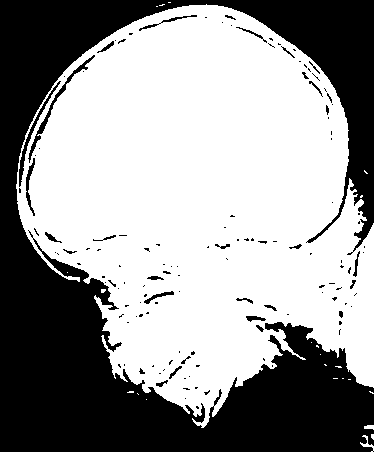

In [4]:
# take 2 intensity level as example
ori_img = load("Data/Fig0221(a).tif")

bit_level = 1
img = ori_img

gray_level = range(0, stop = 1, length= Int(2^bit_level+1))
@show gray_level

# let [0,0.5] be 0
inds = gray_level[1] .< img .<= gray_level[2]
img[inds] = fill(gray_level[1],length(findall(inds)))

# let [0.5,1] be 0.5
inds = gray_level[2] .< img .<= gray_level[3]
img[inds] = fill(gray_level[2],length(findall(inds)))

# normalize image again
img = img./maximum(img) # Array{N0f8}

img = colorview(Gray,img) # convert to Array{Gray{N0f8}}

将上面的idea重写成函数即可

In [5]:
# rewrite as function
function down_intensity!(img::Array{Gray{T}}, dest_bit) where T
    gray_level = range(0, stop = 1, length= Int(2^dest_bit+1))
    inds = [gray_level[i] .< img .<= gray_level[i+1] 
        for i in 1:length(gray_level)-1]
    
    # This for-loop is slow
    for i in 1:length(gray_level)-1
        img[inds[i]] = fill(gray_level[i],length(findall(inds[i])))
    end
    img = Gray{T}.(img/maximum(img))
    return img
end
function down_intensity(img::Array{Gray{T}}, dest_bit) where T
    dest_img = copy(img)
    down_intensity!(dest_img, dest_bit)
end

down_intensity (generic function with 1 method)

Let's see how it works

  0.396846 seconds (390.48 k allocations: 30.418 MiB, 2.94% gc time)
  0.089509 seconds (2.33 k allocations: 7.540 MiB)
  0.058061 seconds (1.21 k allocations: 5.947 MiB)
  0.034090 seconds (623 allocations: 5.150 MiB, 20.09% gc time)
  0.018697 seconds (324 allocations: 4.752 MiB)
  0.010960 seconds (171 allocations: 4.552 MiB)
  0.007430 seconds (94 allocations: 4.453 MiB)
  0.016811 seconds (54 allocations: 4.403 MiB, 38.71% gc time)
Intensity levels are:
256	128	64	32
16	8	4	2


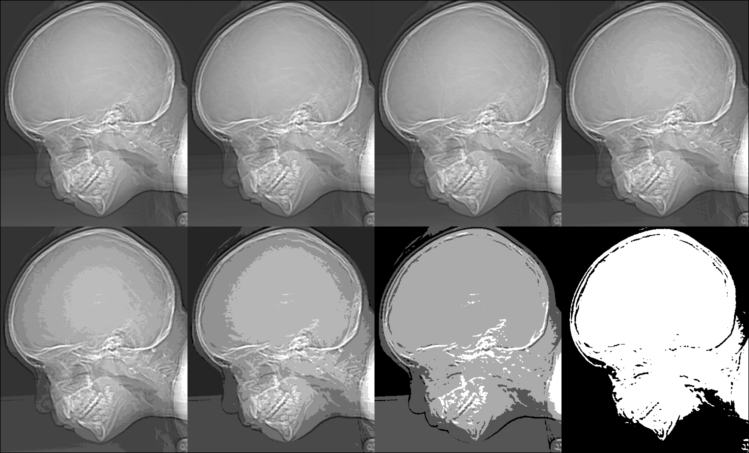

In [6]:
bit_levels = [8:-1:1...]
ori_img = load("Data/Fig0221(a).tif")

imgs = [@time down_intensity(ori_img,bit_level) for bit_level in bit_levels]

@printf "Intensity levels are:\n%d\t%d\t%d\t%d\n%d\t%d\t%d\t%d\n" (2 .^bit_levels)...
[[imgs[1] imgs[2] imgs[3] imgs[4]]
[imgs[5] imgs[6] imgs[7] imgs[8]]]

实际上，`Images`中是支持图片按不同Bit位数表示的，这比自己实现要快得多也要可靠的多

  0.079855 seconds (156.26 k allocations: 7.886 MiB)
  0.179634 seconds (415.89 k allocations: 21.755 MiB, 6.09% gc time)
  0.283459 seconds (395.71 k allocations: 20.622 MiB, 8.79% gc time)
  0.238076 seconds (395.69 k allocations: 20.627 MiB, 9.67% gc time)
  0.250321 seconds (392.75 k allocations: 20.432 MiB, 7.71% gc time)
  0.178140 seconds (395.73 k allocations: 20.626 MiB, 9.01% gc time)
  0.274542 seconds (395.73 k allocations: 20.636 MiB, 6.10% gc time)
  0.198120 seconds (393.82 k allocations: 20.518 MiB, 8.90% gc time)
Intensity levels are:
256	128	64	32
16	8	4	2


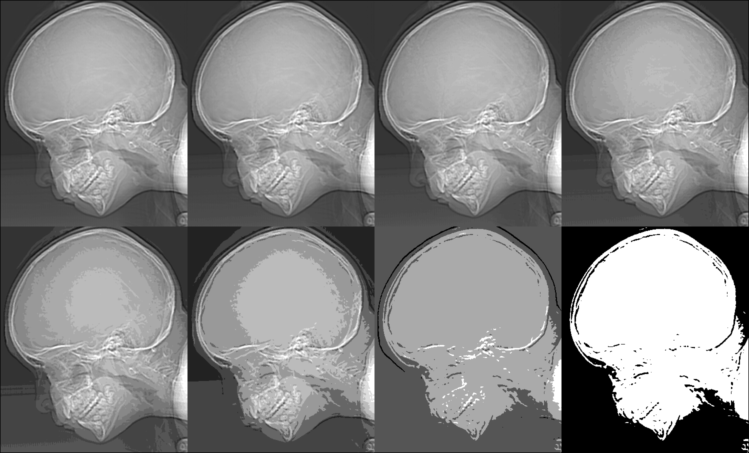

In [7]:
bit_levels = [8:-1:1...]
ori_img = load("Data/Fig0221(a).tif")

imgs = [@time Gray{Normed{UInt8,bit_level}}.(ori_img) # 存储类型转换即可
    for bit_level in bit_levels]

@printf "Intensity levels are:\n%d\t%d\t%d\t%d\n%d\t%d\t%d\t%d\n" (2 .^bit_levels)...
[[imgs[1] imgs[2] imgs[3] imgs[4]]
[imgs[5] imgs[6] imgs[7] imgs[8]]]

可以看到，实际结果上还是有一些差异的

注：由于`FixedPointNumber.Normed`类型在溢出时的行为是wraparound，因此在涉及到溢出的情况下需要做类型转换。

In [8]:
# wraparound behavior for overflow
a = N0f8(0.9)
@show -a
@show a - N0f8(0.91)

-a = 0.102N0f8
a - N0f8(0.91) = 0.996N0f8


0.996N0f8

检查一下两种方法之间的差别

  1.258061 seconds (2.22 M allocations: 110.304 MiB, 4.36% gc time)
  1.142281 seconds (1.33 M allocations: 124.624 MiB, 6.44% gc time)
summary(img_diffs) = "8-element Array{Array{Gray{Float32},2},1}"
Intensity levels are:
256	128	64	32
16	8	4	2


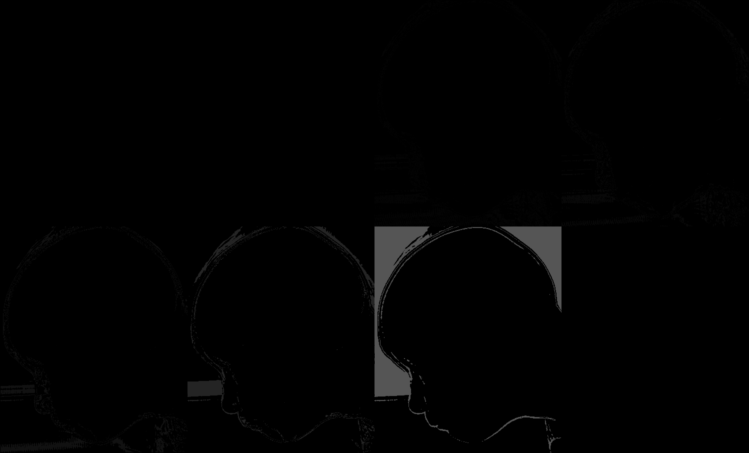

In [9]:
bit_levels = [8:-1:1...]
ori_img = float32.(load("Data/Fig0221(a).tif")) # convert to Float16

@time imgs_builtin = [Gray{Normed{UInt8,bit_level}}.(ori_img)
    for bit_level in bit_levels]
@time imgs_custom = [down_intensity(ori_img,bit_level) for bit_level in bit_levels]

img_diffs = imgs_builtin .- imgs_custom
@show summary(img_diffs)

@printf "Intensity levels are:\n%d\t%d\t%d\t%d\n%d\t%d\t%d\t%d\n" (2 .^bit_levels)...
[[img_diffs[1] img_diffs[2] img_diffs[3] img_diffs[4]]
[img_diffs[5] img_diffs[6] img_diffs[7] img_diffs[8]]]

造一个例子来更直接地展示这两种方法的差别

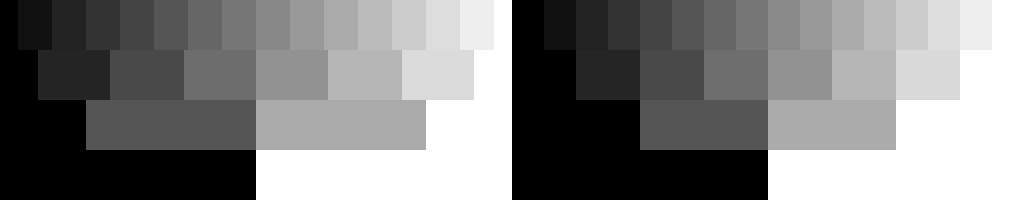

In [10]:
# Let's check the behavior
graybar = Gray{N0f8}.(transpose(repeat(range(0,stop=1,length=512),1,50)))

bits = 4:-1:1
imgs_builtin = [Gray{N0f8}.(Gray{Normed{UInt8, bit}}.(graybar)) for bit in bits] 
imgs_custom = [down_intensity(graybar, bit) for bit in bits]

img_diffs = colorview(Gray,hcat(vcat(imgs_builtin...),vcat(imgs_custom...)))